# Risk Parity & SG Trend Follower Replication

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import datetime as dt

import matplotlib.pyplot as plt

In [2]:
sys.path.append(r"C:\Users\Diego\Desktop\app_prod\research\TrendConvexity\src")
from collectData import DataCollector

# Get Data

In [3]:
def get_data() -> pd.DataFrame: 
    
    df_out = (pd.concat([
        DataCollector().collect_futures().rename(columns = {"PX_LAST": "value"}), 
        DataCollector().collect_fx()]))
    
    return df_out

df = get_data()

## SocGen CTA index replication

In this case we are going to replicate the returns from the CTA index. They use a series of futures and currencies. Using this formulation

$\begin{align}
G_t :&= \sum_{k} G_{k,t}\\
    &= \sum_{k} \Pi_{k, t-1} D_{k,t} \\
    &= \lambda \tau \sum_{k} w_k \cdot \mathcal{L}_{\tau}\left(R_{k,t-1} \right) \cdot R_{k,t} 
\end{align}
$

In this case they set $\lambda = 1$ and they set the weights to be $\frac{1}{N}$. Really this is an equal weighting portfolio of EWMA or prior returns using a $\tau = 180$

Recall that the returns are <br>
$\begin{equation}
R_t = \frac{D_t}{\sigma_{t-1}}\\
\textrm{where}\\
\sigma_t := \gamma \sqrt{\mathcal{L}_{\tau_\sigma}[D_t^2]}
\end{equation}$
Where $D_t^2$ is daily differenced price

In [4]:
def get_sg_cta() -> pd.DataFrame: 
    
    path   = os.path.join(DataCollector().data_path, "hf_indices.parquet")
    df_out = (pd.read_parquet(
        path = path, engine = "pyarrow").
        assign(security = lambda x: x.security.str.split(" ").str[0]).
        query("security == 'NEIXCTA'").
        set_index("date").
        drop(columns = ["security"]))
    
    return df_out

df_sg = get_sg_cta()

In [5]:
def _get_norm_rt(df: pd.DataFrame, tau: int = 10, gamma: float =  1.05) -> pd.DataFrame: 
    
    df_out = (df.sort_values(
        "date").
        assign(
            px_rtn  = lambda x: x.price.pct_change(),
            px_diff = lambda x: x.price.diff(),
            vol     = lambda x: x.px_diff.ewm(span = tau, adjust = False).std() * gamma,
            r_t     = lambda x: x.px_diff / x.vol.shift()))
    
    return df_out

def _get_signal(df: pd.DataFrame, tau: int) -> pd.DataFrame: 
    
    df_out = (df.sort_values(
        "date").
        assign(
            signal     = lambda x: x.r_t.ewm(span = tau, adjust = False).mean(),
            lag_signal = lambda x: x.signal.shift()).
        dropna())
    
    return df_out

def get_signal(df_combined: pd.DataFrame, tau: int = 180) -> pd.DataFrame: 

    df_signal = (df_combined.rename(columns = {
        "value": "price"}).
        groupby("security").
        apply(_get_norm_rt).
        reset_index(drop = True).
        groupby("security").
        apply(_get_signal, tau).
        reset_index(drop = True))
    
    return df_signal

df_signal = get_signal(df)

Now apply the optimization for the signal returns

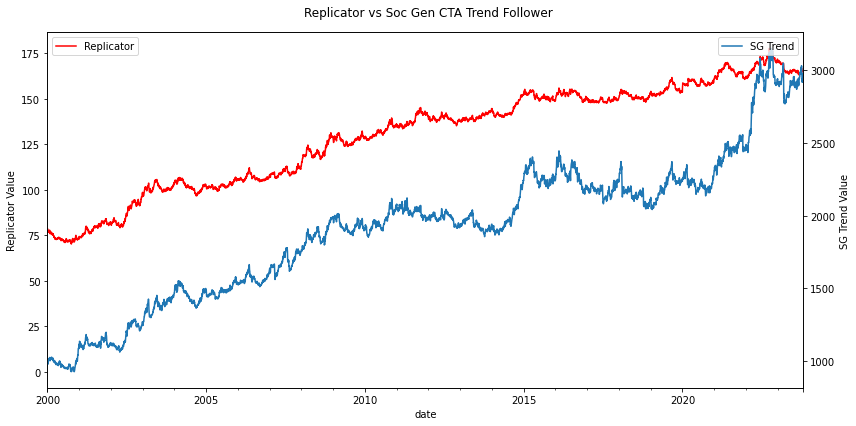

In [7]:
def plot_replicator(df_signal: pd.DataFrame, df_sg: pd.DataFrame) -> plt.Figure: 
    
    fig, axes = plt.subplots(figsize = (12,6))

    (df_signal.assign(
        signal_rtn = lambda x: np.sign(x.lag_signal) * x.r_t)
        [["date", "signal_rtn"]].
        rename(columns = {"signal_rtn": "Replicator"}).
        groupby("date").
        agg("mean").
        cumsum().
        plot(
            ax     = axes,
            color  = "red",
            ylabel = "Replicator Value"))

    axes_twin = axes.twinx()

    (df_sg.rename(
        columns = {"PX_LAST": "SG Trend"}).
        plot(
            ax     = axes_twin,
            ylabel = "SG Trend Value"))

    axes_twin.legend(loc = "upper right")
    fig.suptitle("Replicator vs Soc Gen CTA Trend Follower")
    plt.tight_layout()
    
plot_replicator(df_signal, df_sg)

Although the index looks wrong it appears it is just off by some factor. This can be checked by comparing the correlation. 

In [15]:
def get_correlation(df_signal: pd.DataFrame, df_sg: pd.DataFrame) -> None: 
    
    out_val = (df_signal.assign(
        signal_rtn = lambda x: np.sign(x.lag_signal) * x.r_t)
        [["date", "signal_rtn"]].
        rename(columns = {"signal_rtn": "Replicator"}).
        groupby("date").
        agg("mean").
        cumsum().
        merge(right = df_sg, how = "inner", on = ["date"]).
        corr().
        query("Replicator != 1").
        Replicator.iloc[0])

    print("Correlation {}%".format(round(out_val * 100, 2)))
    
get_correlation(df_signal, df_sg)

Correlation 96.21%
